## CRISP-DM Phase 5. Evaluation

In [100]:
# Dependencies
import sys
sys.path.append('../src')
import utils
import data_processor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import warnings 
warnings.filterwarnings('ignore')

# Load processed data
data: pd.DataFrame = utils.load_preprocessed_data("../data/processed/financial_data_processed.pkl")

# Data preprocessing object
processor = data_processor.DataProcessor(data)
X, y = processor.create_feature_matrix_and_target_vector(target_column="Financial Distress")

# Retrieve test data 
_, X_test , _, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Loading the best classifier (xgboost)
xgb_classifier = pkl.load(open("../artifacts/xgb.pkl", 'rb'))

In [101]:
# Evaluating the Model on test set with Treshold tuning

# Predict probabilities on the test set
xgb_probs_test = xgb_classifier.predict_proba(X_test)[:, 1]

# Apply the tuned threshold to classify instances
tuned_threshold = 0.113677
y_pred_tuned = (xgb_probs_test > tuned_threshold).astype(int)

acccuracy = accuracy_score(y_test, y_pred_tuned)
f1 = f1_score(y_test, y_pred_tuned, average="weighted")
recall = recall_score(y_test, y_pred_tuned, average="weighted")
precision = precision_score(y_test, y_pred_tuned, average="weighted")


print("*************** \n Gradient Boosting Results \n***************")
print("Accuracy    : ", acccuracy)
print("F1 Score    : ", f1)
print("Recall      : ", recall)
print("Precision   : ", precision)

*************** 
 Gradient Boosting Results 
***************
Accuracy    :  0.14972776769509982
F1 Score    :  0.19650120197293705
Recall      :  0.14972776769509982
Precision   :  0.9593874035382821


In [102]:
# Evaluating the Model on test set without Treshold tuning 
y_pred = xgb_classifier.predict(X_test)

acccuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
recall = recall_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")


print("*************** \n Gradient Boosting Results \n***************")
print("Accuracy    : ", acccuracy)
print("F1 Score    : ", f1)
print("Recall      : ", recall)
print("Precision   : ", precision)

*************** 
 Gradient Boosting Results 
***************
Accuracy    :  0.4618874773139746
F1 Score    :  0.5901046749905494
Recall      :  0.4618874773139746
Precision   :  0.9541733295282906


- Threshold tuning yelds worse results than the default threshold (0.5)

In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.44      0.61      1055
           1       0.07      0.94      0.13        47

    accuracy                           0.46      1102
   macro avg       0.53      0.69      0.37      1102
weighted avg       0.95      0.46      0.59      1102



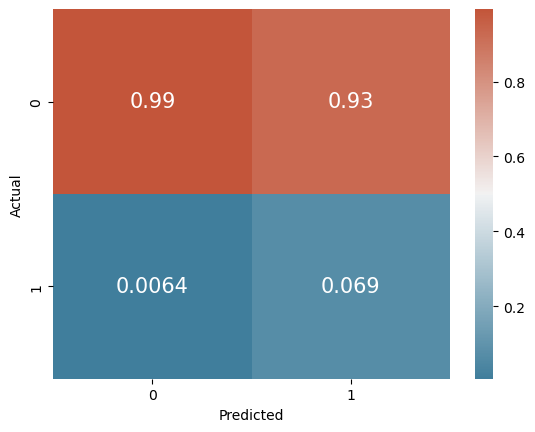

In [103]:
# confusion matrix 
confusion_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted'])
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(confusion_matrix/np.sum(confusion_matrix), cmap=cmap,annot = True, annot_kws = {'size':15})
plt.show()

f1=0.129 auc=0.106 ap=0.110


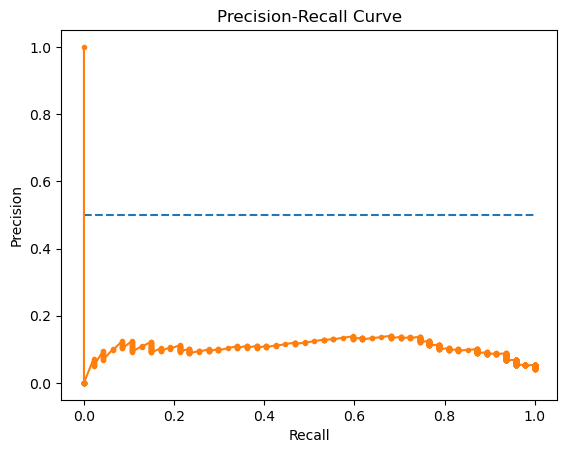

In [106]:
# Evaluate with precision-recall curve and ROC curve and f1-score
# predict probabilities
probs = xgb_classifier.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = xgb_classifier.predict(X_test)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, probs)
# calculate F1 score
f1 = f1_score(y_test, yhat)
# calculate precision-recall AUC
auc_score = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(y_test, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc_score, ap))
# plot no skill
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')
# show the plot
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

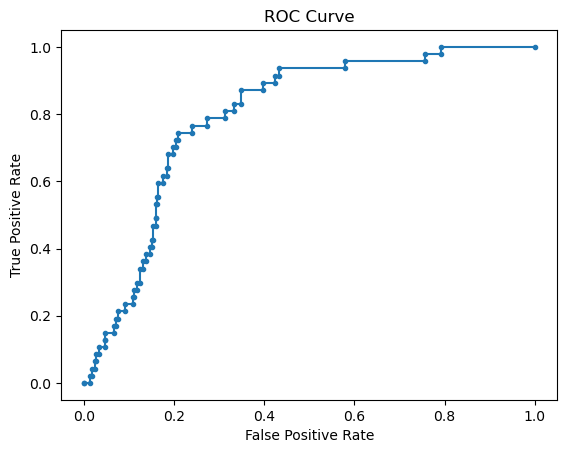

ROC AUC: 0.798


In [87]:
# ROC curve
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# calculate AUC
auc = roc_auc_score(y_test, probs)
# plot the roc curve for the model
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.plot(fpr, tpr, marker='.')
plt.show()
print('ROC AUC: %.3f' % auc)

- Dispite the implemeted techniques to address the imbalance in the data, the model still performs poorly on the minority class.

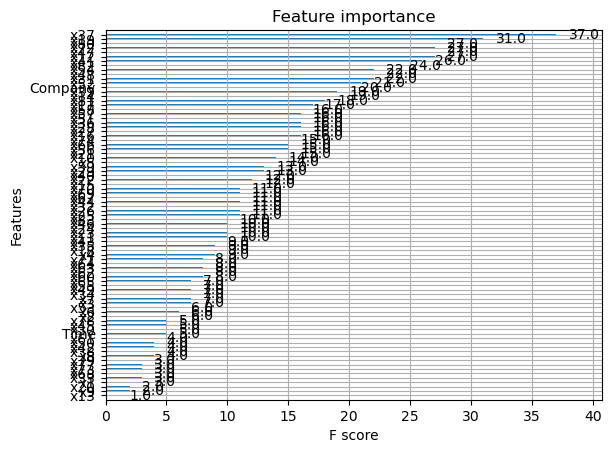

In [31]:
# plot feature importance
from xgboost import plot_importance
plot_importance(xgb_classifier)
plt.show()